In [1]:
import os, sys
import torch
import torchvision.transforms as tvt
from PIL import Image
import numpy as np
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tvt
from torchvision import utils
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import skimage.io as io
from DLStudio import *

In [9]:
class myCOCODataSet_HW5(Dataset):
    def __init__(self, file_path, classes, transform=None):
        super (). __init__ ()
        self.file_path = file_path
        self.classes = classes
        self.image_path = []
        self.class_label = []
        for c in classes:
            image_file_path = os.path.join(file_path, c)
            image_label = self.classes.index(c)
            for l in os.listdir(image_file_path):
                self.image_path.append(os.path.join(image_file_path,l))
                self.class_label.append(image_label)
            
        self.transform = transform

    def __len__(self):
        return len(self.class_label)

    def __getitem__(self, idx):
        image_name_path = self.image_path[idx]
        actual_image_label = self.class_label[idx]
        ##img_path = os.path.join(self.file_path, self.file_names[idx])
        actual_image = Image.open(image_name_path)
        ##og_image = io.imread(img_path)
        ##class_name = self.file_names[idx].split("_")[0] # get the index of label
        ##label = self.classes.index(class_name) # get label
        if self.transform:
           actual_image = self.transform(actual_image)

        return actual_image, actual_image_label

In [10]:
def plot_train_test_image_sample(dataset,classes_plot):
    # Create a dictionary to store indices of images for each class
    class_indices = {class_name: [] for class_name in classes_plot}
    
    # Iterate through the dataset to collect indices for each class
    for idx, (image, label) in enumerate(dataset):
        class_indices[classes[label]].append(idx)
    
    # Display 5 random images from each class
    num_samples_per_class = 3
    fig, axes = plt.subplots(len(classes), num_samples_per_class, figsize=(12, 12))
    
    for i, class_name in enumerate(classes):
        indices = class_indices[class_name]
        random_indices = np.random.choice(indices, num_samples_per_class, replace=False)
        
        for j, idx in enumerate(random_indices):
            image, label = dataset[idx]
            image = np.transpose(image.numpy(), (1, 2, 0))
            axes[i, j].imshow(image)
            axes[i, j].set_title(class_name)
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [11]:
classes = ['boat', 'couch', 'dog', 'cake', 'motorcycle']
file_path_train = '/Users/avnishkanungo/Desktop/coco-dataset/train2017/hw4_dataset/train_data_CNN'
file_path_test = '/Users/avnishkanungo/Desktop/coco-dataset/train2017/hw4_dataset/test_data_CNN'

In [12]:
xform = tvt.Compose([
    tvt.ToTensor()])

In [13]:
my_dataset_test = myCOCODataSet_HW5(file_path = file_path_test, classes = classes ,transform = xform )
my_dataset_train = myCOCODataSet_HW5(file_path = file_path_train, classes = classes ,transform = xform )

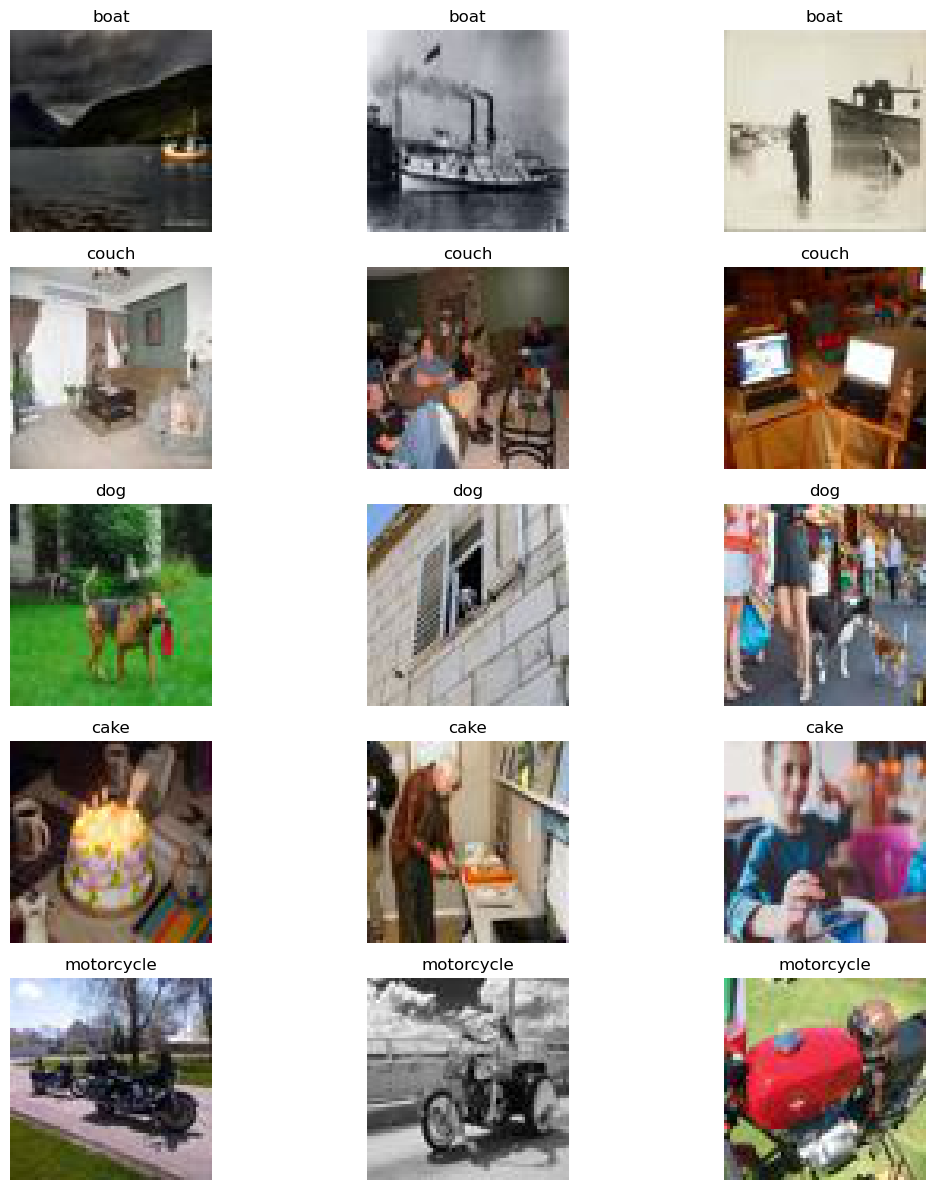

In [15]:
plot_train_test_image_sample(my_dataset_train, classes)

In [16]:
train_dataloader = DataLoader(my_dataset_train, batch_size = 4, shuffle=True)
test_dataloader = DataLoader(my_dataset_test,batch_size = 4, shuffle=True)

In [130]:
def weights_init(m): # to help prevent vanishing gradient problem 
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight)

In [209]:
 class SkipBlock_1(nn.Module):
     def __init__(self, in_ch, out_ch, downsample=False, skip_connections=True):
         super(SkipBlock_1, self).__init__()
         self.downsample = downsample
         self.skip_connections = skip_connections
         self.in_ch = in_ch
         self.out_ch = out_ch
         self.convo1 = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
         self.convo2 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
         self.bn1 = nn.BatchNorm2d(in_ch)
         self.bn2 = nn.BatchNorm2d(out_ch)
         self.in2out  =  nn.Conv2d(in_ch, out_ch, 1)                            ###  <<<<<  from  Cheng-Hao Chen
         if downsample:
             ##  Setting stride to 2 and kernel_size to 1 amounts to retaining every
             ##  other pixel in the image --- which halves the size of the image:
             self.downsampler1 = nn.Conv2d(in_ch, in_ch, 1, stride=2)
             self.downsampler2 = nn.Conv2d(out_ch, out_ch, 1, stride=2)

     
     def forward(self, x):
         identity = x                                     
         out = self.convo1(x)                              
         out = self.bn1(out)                              
         out = nn.functional.relu(out)
         out = self.convo2(out)                              
         out = self.bn2(out)                              
         out = nn.functional.relu(out)
         if self.downsample:
             identity = self.downsampler1(identity)
             out = self.downsampler2(out)
         if self.skip_connections:
             if (self.in_ch == self.out_ch) and (self.downsample is False):
                 out = out + identity
             elif (self.in_ch != self.out_ch) and (self.downsample is False):
                 identity = self.in2out( identity )                             ###  <<<<  from  Cheng-Hao Chen
                 out = out + identity
             elif (self.in_ch != self.out_ch) and (self.downsample is True):
                 out = out + torch.cat((identity, identity), dim=1)
         return out

In [210]:
class HWNet5_1(nn.Module):
    def __init__(self, skip_connections=True, depth=8):
        super(HWNet5_1, self).__init__()
        self.depth = depth
        self.conv = nn.Conv2d(3, 64, 3, padding=1)
        self.skip64_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip64_arr.append(SkipBlock_1(64, 64, skip_connections=skip_connections))
        self.skip64to128ds = SkipBlock_1(64, 128, downsample=True, skip_connections=skip_connections )
        self.skip128_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip128_arr.append(SkipBlock_1(128, 128, skip_connections=skip_connections))
        self.skip128to256ds = SkipBlock_1(128, 256, downsample=True, skip_connections=skip_connections )
        self.skip256_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip256_arr.append(SkipBlock_1(256, 256, skip_connections=skip_connections))
        self.fc1 =  nn.Linear(16384, 1000)
        self.fc2 =  nn.Linear(1000, 5)

    def forward(self, x):
        x = nn.MaxPool2d(2,2)(nn.functional.relu(self.conv(x)))          
        for skip64 in self.skip64_arr:
            x = skip64(x)                
        x = self.skip64to128ds(x)
        for skip128 in self.skip128_arr:
            x = skip128(x)                
        x = self.skip128to256ds(x)
        for skip256 in self.skip256_arr:
            x = skip256(x)                
        x  =  x.view( x.shape[0], - 1 )
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [212]:
net1_test = HWNet5_1()
net1_test.apply(weights_init)
epochs_net1_test = 15
batch_size_net1_test = 4
lr1 = 1e-3
net1_test_training_loss = model_training(net1_test, epochs_net1_test, train_dataloader, torch.device("mps"), os.path.join('/Users/avnishkanungo/Desktop/coco-dataset/train2017/hw5_dataset', 'net1_test.pth'),lr1)
confusion_matrix_net1_test, net1_test_testing_acc = model_testing(net1_test, test_dataloader, batch_size_net1_test, torch.device("mps"), classes,os.path.join('/Users/avnishkanungo/Desktop/coco-dataset/train2017/hw5_dataset', 'net1_test.pth'))

Begin Training...

[epoch: 1, batch:   100] loss: 18.591318
[epoch: 1, batch:   200] loss: 1.595869
[epoch: 1, batch:   300] loss: 1.606734
[epoch: 1, batch:   400] loss: 1.578372
[epoch: 1, batch:   500] loss: 1.524059
[epoch: 1, batch:   600] loss: 1.604181
[epoch: 1, batch:   700] loss: 1.643618
[epoch: 1, batch:   800] loss: 1.599703
[epoch: 1, batch:   900] loss: 1.612106
[epoch: 1, batch:  1000] loss: 1.624000
[epoch: 1, batch:  1100] loss: 1.761590
[epoch: 1, batch:  1200] loss: 1.612448
[epoch: 1, batch:  1300] loss: 1.609450
[epoch: 1, batch:  1400] loss: 1.609361
[epoch: 1, batch:  1500] loss: 1.609207
[epoch: 1, batch:  1600] loss: 1.610274
[epoch: 1, batch:  1700] loss: 1.609817
[epoch: 1, batch:  1800] loss: 1.609055
[epoch: 1, batch:  1900] loss: 1.608263
[epoch: 1, batch:  2000] loss: 1.608677
[epoch: 2, batch:   100] loss: 1.609747
[epoch: 2, batch:   200] loss: 1.609608
[epoch: 2, batch:   300] loss: 1.609677
[epoch: 2, batch:   400] loss: 1.610791
[epoch: 2, batch:   

KeyboardInterrupt: 

In [160]:
## This code has been taken from Professor Kak' DL Studio Model and 
## and in part also configured by referenceing previous year's homework.

class SkipBlock(nn.Module):
     def __init__(self, in_ch, out_ch, downsample=False, skip_connections=True):
        super(SkipBlock, self).__init__()
        self.downsample = downsample
        self.skip_connections = skip_connections
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.convo1 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
        self.convo2 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        if downsample:
             ##  Setting stride to 2 and kernel_size to 1 amounts to retaining every
            ##  other pixel in the image --- which halves the size of the image:
            self.downsampler = nn.Conv2d(in_ch, out_ch, 1, stride=2)

     def forward(self, x):
        identity = x      #store the incoming data, image data                                
        out = self.convo1(x)                              
        out = self.bn1(out)                              
        out = nn.functional.relu(out)
        if self.in_ch == self.out_ch:  
            out = self.convo2(out)                              
            out = self.bn2(out)                              
            out = nn.functional.relu(out)
        if self.downsample:
            out = self.downsampler(out)
            identity = self.downsampler(identity)
        if self.skip_connections:
            if self.in_ch == self.out_ch:
#                out += identity  
                out = out + identity
            else:
                        ## To understand the following assignments, recall that the data has the
                        ## shape [B,C,H,W]. So it is the second axis that corresponds to the channels
#                        out[:,:self.in_ch,:,:] += identity
#                        out[:,self.in_ch:,:,:] += identity
                out = out + torch.cat((identity, identity), dim=1)
        return out

In [161]:
## This code has been taken from Professor Kak' DL Studio Model and 
## and in part also configured by referenceing previous year's homework.

class HW5Net(nn.Module):
    def __init__(self, skip_connections=True, depth=32):
        super(HW5Net, self).__init__()
        self.depth = depth // 8
        self.conv = nn.Conv2d(3, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.skip64_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip64_arr.append(SkipBlock(64, 64,skip_connections=skip_connections))
        self.skip64ds1 = SkipBlock(64, 64, downsample=True, skip_connections=skip_connections) # Bug fix as professor mentioned in the class
        self.skip64ds2 = SkipBlock(64, 64, downsample=True, skip_connections=skip_connections) # Bug fix as professor mentioned in the class
        self.skip64to128 = SkipBlock(64, 128,skip_connections=skip_connections )
        self.skip128_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip128_arr.append(SkipBlock(128, 128,skip_connections=skip_connections))
        self.skip128ds = SkipBlock(128,128,downsample=True, skip_connections=skip_connections)
                ##  The following declaration is predicated on the assumption that the number of
                ##  output nodes (CxHxW) from the final convo layer exactly 2048 for each
                ##  input image.  Depending on the size of the input image, this places a constraint
                ##  on how many downsampling instances of SkipBlock you can call in a network.
        self.fc1 =  nn.Linear(8192, 1000)
        self.fc2 =  nn.Linear(1000, 5) # changed output to 5 as that is the number of classes that we are using. 
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv(x)))          
        for i,skip64 in enumerate(self.skip64_arr[:self.depth//4]):
            x = skip64(x)                
        x = self.skip64ds1(x) # Bug fix as professor mentioned in the class
        # x = self.skip64ds2(x)
        for i,skip64 in enumerate(self.skip64_arr[self.depth//4:]):
            x = skip64(x)                
        x = self.skip64ds2(x) # Bug fix as professor mentioned in the class
        x = self.skip64to128(x)
        for i,skip128 in enumerate(self.skip128_arr[:self.depth//4]):
            x = skip128(x)                
        for i,skip128 in enumerate(self.skip128_arr[self.depth//4:]):
            x = skip128(x)                
        ## See the comment block above the "self.fc1" declaration in the constructor code.
        x  =  x.view( x.shape[0], - 1 )
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [162]:
## This code has been taken from Professor Kak' DL Studio Model and 
## and in part also configured by referenceing previous year's homework.

def model_training(net, epochs, train_data_loader, device, save_path, lr=0.0001):
    training_loss = []
    criterion = torch.nn.CrossEntropyLoss() #Loss Function
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.99)) #Optimizer
    print("Begin Training...\n")
    net = net.to(device) #Configure Device
    net.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_data_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() #initializer gradient values to zero
            outputs = net(inputs) #forward pass
            loss = criterion(outputs, labels) # loss calculated as per the cost function
            loss.backward() #backpropogation of the loss
            optimizer.step()  #step optimization as per the optimizer configured
            running_loss += loss.item()
            if (i + 1) % 100 == 0:
                print("[epoch: %d, batch: %5d] loss: %3f" % (epoch + 1, i + 1, running_loss / 100))
                training_loss.append(running_loss / 100)
                running_loss = 0.0
    print("Finished Training!\n")
    torch.save(net.state_dict(), save_path)
    plot_training_loss(training_loss)
    return training_loss

In [163]:
## This code has been taken from Professor Kak' DL Studio Model and 
## and in part also configured by referenceing previous year's homework.

def model_testing(net, test_data_loader, batch_size, device, desired_cats, save_path):
    print("Begin Evaluation...\n")
    net.load_state_dict(torch.load(save_path))  #load the saved model from the .pth file
    net.eval()
    correct, total = 0, 0
    confusion_matrix = torch.zeros(5, 5)  #initialize the matrix for confusion matrix creation
    class_correct = [0] * 5
    class_total = [0] * 5
    with torch.no_grad():
        for i, data in enumerate(test_data_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            output = net(inputs) #forward pass
            _, predicted = torch.max(output.data, 1) #extracting index of the max value, as that is basically the label we are looking for
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            comp = predicted == labels
            for label, prediction in zip(labels, predicted):
                confusion_matrix[label][prediction] += 1 #creating the 
            for j in range(batch_size):
                label = labels[j]
                class_correct[label] += comp[j].item()
                class_total[label] += 1
    for j in range(5):
        print('Prediction accuracy for %5s : %2d %%' % (desired_cats[j], 100 * class_correct[j] / class_total[j]))
    print("Finished Evaluation!\n")
    print('Validation Accuracy of the network on 2000 test images: {}%'.format(100 * float(correct / total)))
    plot_confusion_martix(confusion_matrix, 'Confusion Matrix', desired_cats)
    return confusion_matrix, float(correct / total)

In [164]:
def plot_confusion_martix(cf_matrix, title, desired_cats):
    sns.heatmap(cf_matrix, annot=True, cmap='Greens', fmt='g', xticklabels=desired_cats, yticklabels=desired_cats)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title(title)
    plt.show()

In [165]:
def plot_training_loss(training_loss):
    plt.figure()     
    plt.plot(training_loss)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title("Training Loss")
    plt.show()

In [166]:
net1 = HW5Net()
net1.apply(weights_init)
epochs_net1 = 15
batch_size_net1 = 4
lr1 = 1e-3
net1_training_loss = model_training(net1, epochs_net1, train_dataloader, torch.device("mps"), os.path.join('/Users/avnishkanungo/Desktop/coco-dataset/train2017/hw5_dataset', 'net1.pth'),lr1)
confusion_matrix_net1, net1_testing_acc = model_testing(net1, test_dataloader, batch_size_net1, torch.device("mps"), classes,os.path.join('/Users/avnishkanungo/Desktop/coco-dataset/train2017/hw5_dataset', 'net1.pth'))

Begin Training...

[epoch: 1, batch:   100] loss: 5.707653
[epoch: 1, batch:   200] loss: 1.484862
[epoch: 1, batch:   300] loss: 1.650986
[epoch: 1, batch:   400] loss: 1.658330
[epoch: 1, batch:   500] loss: 1.574159
[epoch: 1, batch:   600] loss: 1.504260
[epoch: 1, batch:   700] loss: 1.679240
[epoch: 1, batch:   800] loss: 1.575386
[epoch: 1, batch:   900] loss: 1.526862
[epoch: 1, batch:  1000] loss: 1.511343
[epoch: 1, batch:  1100] loss: 1.576032
[epoch: 1, batch:  1200] loss: 1.524304
[epoch: 1, batch:  1300] loss: 1.553198
[epoch: 1, batch:  1400] loss: 1.501386
[epoch: 1, batch:  1500] loss: 1.509644
[epoch: 1, batch:  1600] loss: 1.498389
[epoch: 1, batch:  1700] loss: 1.425769
[epoch: 1, batch:  1800] loss: 1.500700
[epoch: 1, batch:  1900] loss: 1.550291
[epoch: 1, batch:  2000] loss: 1.551757
[epoch: 2, batch:   100] loss: 1.436237
[epoch: 2, batch:   200] loss: 1.444692
[epoch: 2, batch:   300] loss: 1.421429
[epoch: 2, batch:   400] loss: 1.477727
[epoch: 2, batch:   5

KeyboardInterrupt: 

Begin Training...

[epoch: 1, batch:   100] loss: 1.719484
[epoch: 1, batch:   200] loss: 1.649701
[epoch: 1, batch:   300] loss: 1.471299
[epoch: 1, batch:   400] loss: 1.551539
[epoch: 1, batch:   500] loss: 1.483722
[epoch: 1, batch:   600] loss: 1.501474
[epoch: 1, batch:   700] loss: 1.440828
[epoch: 1, batch:   800] loss: 1.472165
[epoch: 1, batch:   900] loss: 1.414100
[epoch: 1, batch:  1000] loss: 1.350329
[epoch: 1, batch:  1100] loss: 1.367038
[epoch: 1, batch:  1200] loss: 1.325805
[epoch: 1, batch:  1300] loss: 1.354949
[epoch: 1, batch:  1400] loss: 1.377854
[epoch: 1, batch:  1500] loss: 1.355783
[epoch: 1, batch:  1600] loss: 1.306181
[epoch: 1, batch:  1700] loss: 1.270772
[epoch: 1, batch:  1800] loss: 1.367891
[epoch: 1, batch:  1900] loss: 1.341804
[epoch: 1, batch:  2000] loss: 1.338977
[epoch: 2, batch:   100] loss: 1.133338
[epoch: 2, batch:   200] loss: 1.105303
[epoch: 2, batch:   300] loss: 1.169302
[epoch: 2, batch:   400] loss: 1.091798
[epoch: 2, batch:   5

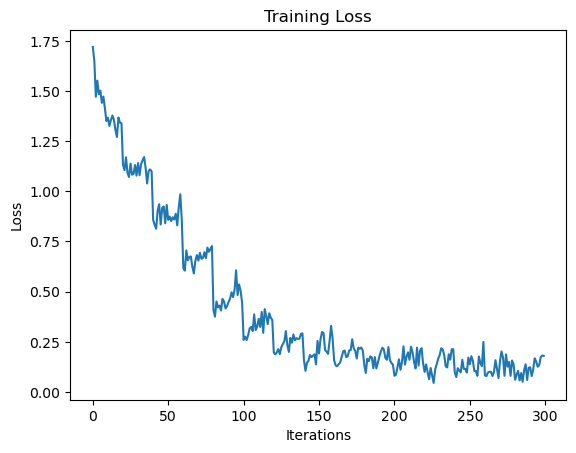

Begin Evaluation...

Prediction accuracy for  boat : 60 %
Prediction accuracy for couch : 45 %
Prediction accuracy for   dog : 24 %
Prediction accuracy for  cake : 70 %
Prediction accuracy for motorcycle : 52 %
Finished Evaluation!

Validation Accuracy of the network on 2000 test images: 50.24999999999999%


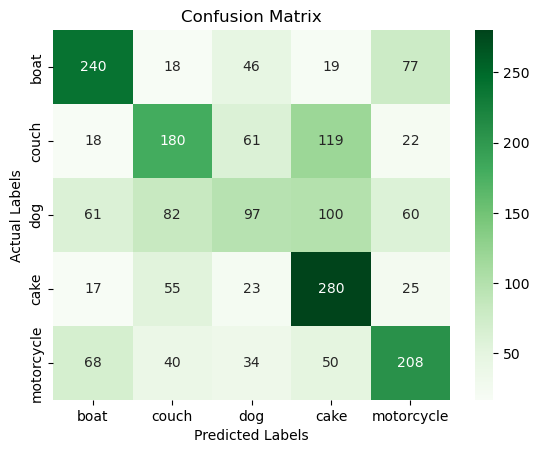

In [137]:
net2 = HW5Net()
net2.apply(weights_init)
epochs_net2 = 15
batch_size_net2 = 4
lr2 = 2e-5
net2_training_loss = model_training(net2, epochs_net2, train_dataloader, torch.device("mps"), os.path.join('/Users/avnishkanungo/Desktop/coco-dataset/train2017/hw5_dataset', 'net2.pth'),  lr2)
confusion_matrix_net2, net2_testing_acc = model_testing(net2, test_dataloader, batch_size_net2, torch.device("mps"), classes,os.path.join('/Users/avnishkanungo/Desktop/coco-dataset/train2017/hw5_dataset', 'net2.pth'))

In [96]:
def count_parameters(model):  #Count network parameters
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [135]:
count_parameters(net_test)

11775093

In [215]:
len(list(net1.parameters()))

108

In [213]:
net_test = HW5Net()